In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from numpy.fft import fft, ifft, fftfreq
from scipy import signal
from astropy.stats import LombScargle
from nfft import ndft, nfft, ndft_adjoint, nfft_adjoint
from gatspy.periodic import LombScargleFast
import time
import pdb
plt.style.use('seaborn')

In [2]:
help(LombScargle.autopower)

Help on function autopower in module astropy.stats.lombscargle.core:

autopower(self, method='auto', method_kwds=None, normalization=None, samples_per_peak=5, nyquist_factor=5, minimum_frequency=None, maximum_frequency=None)
    Compute Lomb-Scargle power at automatically-determined frequencies.
    
    Parameters
    ----------
    method : string (optional)
        specify the lomb scargle implementation to use. Options are:
    
        - 'auto': choose the best method based on the input
        - 'fast': use the O[N log N] fast method. Note that this requires
          evenly-spaced frequencies: by default this will be checked unless
          ``assume_regular_frequency`` is set to True.
        - 'slow': use the O[N^2] pure-python implementation
        - 'cython': use the O[N^2] cython implementation. This is slightly
          faster than method='slow', but much more memory efficient.
        - 'chi2': use the O[N^2] chi2/linear-fitting implementation
        - 'fastchi2': use 

## SNR para datos equiespaciados

choosen freq is:  3.506849315068493


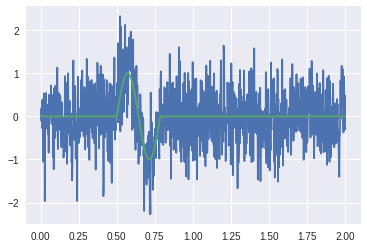

In [3]:
# sinusoidal signal
def signal_equip(N):
    dt = 2 / N
    t = np.linspace(0, N * dt, N)
    t = t + dt
#     print("min of t: ", min(t))
    temp = np.zeros(N)
    segment_duration = int(N/7)
    freq_sin = 1 / (segment_duration * dt)
    print("choosen freq is: ", freq_sin)
    temp[int(N/4): int(N/4) + segment_duration] = np.sin(freq_sin * 2 * np.pi * t[:segment_duration])
    return temp, freq_sin, dt, t

# set data
# np.random.seed(13241)
N = 1024  # should be even for simplicity
temp, freq_sin, dt, t = signal_equip(N)
data = np.random.normal(0, 0.6, N) + temp
plt.plot(t, data)
plt.plot(t, temp)

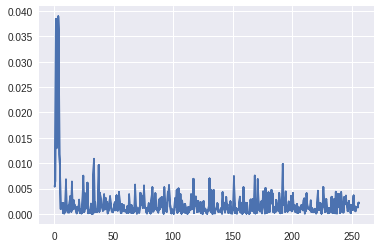

In [4]:
# obtencion de la psd usando las frequencias de numpy.fft
def get_scipy_psd(N, dt, t, data):
    freqs = fftfreq(N, d=dt)
    freqs_abs = np.abs(freqs)
    freqs_lomb = np.delete(freqs_abs, 0)
    pgram_fft = signal.lombscargle(t, data, freqs_lomb * 2 * np.pi, normalize=True)
    return freqs_lomb, pgram_fft

freqs_lomb, pgram_fft = get_scipy_psd(N, dt, t, data)
plt.plot(freqs_lomb, pgram_fft)

[3.50272735e-03 2.05007291e+01 3.94135458e+01 5.53147010e+01
 6.70890087e+01 7.40373399e+01 7.59349200e+01 7.30345637e+01
 6.60160691e+01 5.58897666e+01]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]


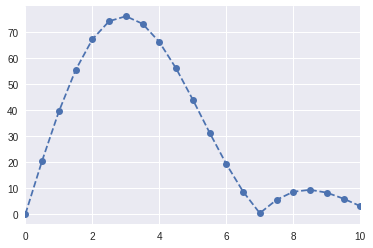

In [5]:
# las fft
def get_fft(N, temp, data):
    dwindow = signal.tukey(len(temp), alpha=1./8)
    # pgram = np.mean(pgram)
    fft_d = fft(dwindow * data)
    fft_t = fft(dwindow * temp)
    return fft_d, fft_t

fft_d, fft_t = get_fft(N, temp, data)
freqs = fftfreq(N, d=dt)
plt.plot(freqs[:int(N/2)], np.abs(fft_t[:int(N/2)]), 'o--')
plt.xlim([0,10])

print(np.abs(fft_t[0:10]))
print(freqs[0:10])

In [6]:
# realizando una pequeña revision del teorema de parseval
sum_time = (np.abs(temp)**2).sum()
sum_freq = (np.abs(fft_t)**2).sum()
print(sum_time, sum_freq/N)
# vemos que coincide cuando dividimos la suma en frequencias por N, esto es dividir las frequencias por raiz de N
sum_freq = (np.abs(fft_t/np.sqrt(N))**2).sum()
print(sum_time, sum_freq/N)
print("\n ------------ \n")

# aprovechemos de revisar la invera
temp_inv = ifft(fft_t)
sum_time_inv = (np.abs(temp_inv)**2).sum()
print(sum_time, sum_time_inv)
# vemos que en la inversa se corrige esto, si por otro lado a la inversa le ingreso una fft dividida por sqrt(N)
temp_inv = ifft(fft_t/np.sqrt(N))
sum_time_inv = (np.abs(temp_inv)**2).sum()
print(sum_time, sum_time_inv*N)
# se hace necesario multiplicar por raiz de N, esto es claro por que las constantes en fourier se puede sacar.
# luego si el objetivo final es aplicar ifft de fft no es necesario normalizar

72.9287753976131 72.9287753976131
72.9287753976131 0.07121950722423154

 ------------ 

72.9287753976131 72.9287753976131
72.9287753976131 72.9287753976131


choosen freq is:  3.506849315068493
1.3845578616363647 3.6204969881145206


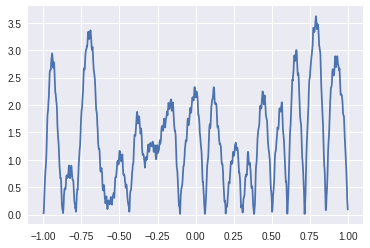

In [7]:
#las fft
def snr_equip(N, only_noise=False):
    temp, freq_sin, dt, t = signal_equip(N)
    if only_noise:
        data = np.random.normal(0, 0.6, N)
    else:
        data = np.random.normal(0, 0.6, N) + temp
        
    freqs_lomb, pgram_fft = get_scipy_psd(N, dt, t, data)
    dwindow = signal.tukey(len(temp), alpha=1./8)
    # pgram = np.mean(pgram)
    fft_d = fft(dwindow * data)
    fft_t = fft(dwindow * temp)
    fft_d = np.delete(fft_d, 0) # remving the value corresponding to 0 frequency
    fft_t = np.delete(fft_t, 0)
    
    df = 2 / (N * dt)
    norm_sigma = 4 * df
    h_norm = (fft_t * fft_t.conjugate() / pgram_fft).sum()
    norm_corr = 4 * df / np.sqrt(h_norm.real * norm_sigma)
    corr = fft_d * fft_t.conjugate() / pgram_fft
    snr = ifft(corr) * norm_corr * dt * (len(fft_d) - 1)
    snr = np.roll(snr, len(snr) // 2)
    return t, np.abs(snr) 

N = 1024
t, snr = snr_equip(N, only_noise=True)# 
plt.figure(2)
t = np.delete(t, len(t)-1)
plt.plot(t - t[len(t)//2], snr)
print(np.mean(snr), max(snr))


In [8]:
# analicemos el error asociado a muchas repeticiones
def repeat_snr(N, n_repeat, only_noise=False):
    mean_snr = []
    max_snr = []
    median_snr = []
    std_snr = []
    for i in range(n_repeat):
        _, snr = snr_equip(N, only_noise=only_noise)
        mean_snr.append(np.mean(snr))
        median_snr.append(np.median(snr))
        max_snr.append(np.max(snr))
        std_snr.append(np.std(snr))
    return mean_snr, median_snr, max_snr, std_snr

rep = 100
mean, median, maxx, stdd = repeat_snr(1024, rep, only_noise=True)
print(":::::SNR parameters for {} repetitions for signal of only noise:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))
print("\n -------------------------- \n")
mean, median, maxx, stdd = repeat_snr(1024, rep, only_noise=False)
print(":::::SNR parameters for {} repetitions for signal of noise + template:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))

choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.506849315068493
choosen freq is:  3.50684931

choosen freq is:  3.500854700854701
4096 4096
mean is  74.57133966634586 and std is  60.80277667880713
2
mean value is  0.017998295297270338
duration of template is:  2.00048828125
matched filter occurs when the templase has peak at time  2.0
and originally the matched filter has the peak at 0.7145297952915141
and originally the matched filter has the peak at 0.5714284521901709


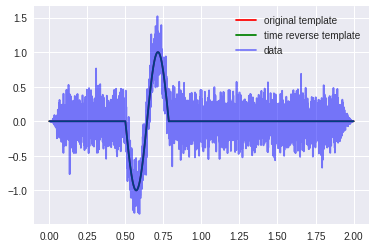

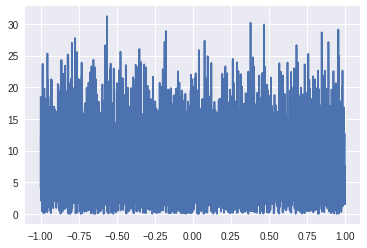

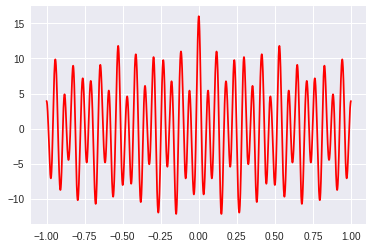

In [23]:
# defining a new SNR
def snr_test(temp, data, dt, fs=1, N0=1, whitened=False, noise=None, bandPass=False, cutoff=None):
    N = len(temp)
    
    if whitened:
        if noise is None:
            _, Pxx = signal.welch(data, fs, noverlap=int(N * 5 / 10), 
                                  nperseg=N, return_onesided=False)
        else:
            _, Pxx = signal.welch(noise, fs, noverlap=int(N * 5 / 10), 
                                  nperseg=N, return_onesided=False)
    else:
        Pxx = 1
        
    if bandPass:
        cufott = fs/2 - 1 if cutoff is None else cutoff
        bb, ab = signal.butter(4, cutoff*2./fs, btype='lowpass')
        data = signal.filtfilt(bb, ab, data)
        temp = signal.filtfilt(bb, ab, temp)
        
    fft_d = fft(data)
    fft_t = fft(temp)
    df = 1 / (N * dt)
    sigma_square = df * (fft_t * fft_t.conjugate() / Pxx).sum()
    corr = ifft(fft_d * fft_t.conjugate() / Pxx)
    snr = corr / np.sqrt(sigma_square) / np.sqrt(N0/2)
    return snr

N = 1024 * 4
dwindow = signal.tukey(N, alpha=1./8)
temp, freq_sin, dt, t = signal_equip(N)
temp = -temp
print(len(t), len(temp))
data_noise = np.random.normal(0, 0.2, N)
data = data_noise + temp

# window data/temp
temp = dwindow * temp
data = dwindow * data
data_noise = dwindow * data_noise

# time reverse of template
temp2 = temp

plt.figure()
plt.plot(t, temp, 'r', label="original template")
plt.plot(t, temp2, 'g', label="time reverse template")
plt.plot(t, data, 'b', alpha=0.5, label="data")
plt.legend()

# some params
fs = N / (max(t) - min(t))
whitened = True
bandPass = False
cutoff = 10

# estimate n0
snr_max_arr = []
for i in range(100):
    only_noise = np.random.normal(0, 0.2, N)
    snr = snr_test(only_noise, np.flip(only_noise, 0), dt, fs=fs, whitened=whitened, 
                   noise=only_noise, bandPass=bandPass, cutoff=cutoff)
    snr_max_arr.append(max(np.abs(snr)))

snr_max = np.mean(snr_max_arr)
snr_max_dev = np.std(snr_max_arr)
print("mean is ", snr_max, "and std is ", snr_max_dev)
n0 = (snr_max**2)/2
n0 = 2
print(n0)
snr = snr_test(data_noise, np.flip(data_noise, 0), dt, N0=n0, fs=fs, whitened=whitened, 
               noise=data_noise, bandPass=bandPass, cutoff=cutoff)

plt.figure()
plt.plot(t - t[N//2], np.roll(np.abs(snr.real), N//2))
print("mean value is ", np.mean(snr.real))

snr2 = snr_test(temp2, temp, dt, N0=n0, fs=fs, whitened=whitened, noise=data,
                bandPass=bandPass, cutoff=cutoff)

snr3 = snr_test(temp2, data, dt, N0=n0, fs=fs, whitened=False, noise=None,
                bandPass=bandPass, cutoff=cutoff)
plt.figure()
plt.plot(t - t[N//2], np.roll(snr2.real, N//2), 'r')
# plt.plot(t, snr3.real / min(snr3.real), 'g')

# match optimal to see
idx_snr_max = np.abs(snr2.real).argmax()
time_of_max = t[idx_snr_max]
print("duration of template is: ", max(t))
print("matched filter occurs when the templase has peak at time ", (max(t) - time_of_max))
print("and originally the matched filter has the peak at", t[(temp).argmax()])
print("and originally the matched filter has the peak at", t[(temp).argmin()])


(0, 100)

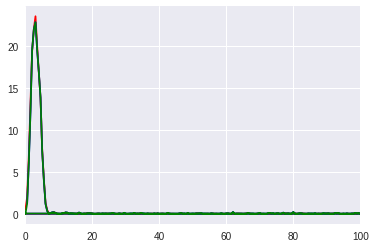

In [59]:
freq_pxx, Pxx = signal.welch(data, fs, noverlap=int(N * 5 / 10), 
                                  nperseg=N, return_onesided=False, scaling="spectrum")
power = LombScargle(t, data).power(freq_pxx, normalization='psd')
fft_d = fft(data)
T = max(t) - min(t)
plt.plot(freq_pxx, fs*Pxx, 'r')
plt.plot(freq_pxx, power, 'b')
plt.plot(fftfreq(N, d=dt), (np.abs(fft_d)**2)/N, 'g')
plt.xlim([0, 100])

0.0025027104326101786

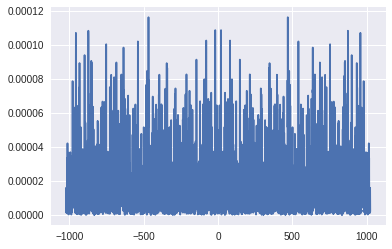

In [77]:
freq_pxx, Pxx = signal.welch(data_noise, fs, noverlap=int(N * 5 / 10), 
                                  nperseg=N, return_onesided=False, scaling="density")
plt.plot(freq_pxx, Pxx)
E = np.sum(Pxx)

expo = np.exp((-1/2) * (1**2)/E)

expo / np.sqrt(2 * np.pi * E)

1365 2730
[0.000e+00 1.000e-01 2.000e-01 ... 1.363e+02 1.364e+02 1.365e+02]
1365 2730
[1.365e+02 1.364e+02 1.363e+02 ... 2.000e-01 1.000e-01 0.000e+00]


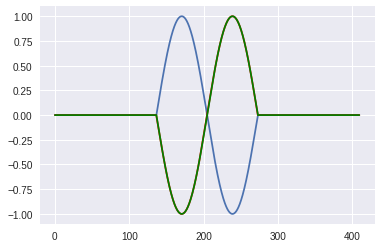

In [10]:
def get_data(t, f=None, n_peaks=1, amp=1, noise=None):
    baseline = max(t) - min(t)
    idx1 = (np.abs(t - min(t) - baseline/3)).argmin()
    idx2 = (np.abs(t - min(t) - 2 * baseline/3)).argmin()
    start = idx1 if idx1<idx2 else idx2
    end = idx2 if idx1<idx2 else idx1
    if f is None:
        f = n_peaks / (t[end] - t[start])
    print(start, end)
    data = np.zeros(len(t))
    print(t[start:end+1] - min([t[start], t[end]]))
    data[start:end+1] = amp * np.sin(2 * np.pi * f * (t[start:end+1] - min([t[start], t[end]])))
    
    if noise is None:
        noise = np.random.normal(0, 0.3, len(t))
        
    return data + noise

N = 1024 * 4
dt = 0.1
t = np.arange(N) * dt
data = get_data(t, noise=np.zeros(N))
data_reverse = get_data(max(t) - t, noise=np.zeros(N))

plt.plot(t, data)
plt.plot(max(t) - t, data, 'r')
plt.plot(t, np.flip(data, 0), 'g')
# def get_n0(repetitions=10):
    

choosen freq is:  3.500854700854701
4096 4096


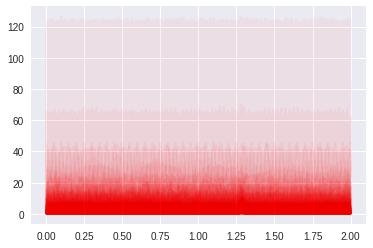

In [11]:
N = 1024 * 4
dwindow = signal.tukey(N, alpha=1./8)
temp, freq_sin, dt, t = signal_equip(N)
temp = -temp
# time reverse of template
temp2 = np.flip(temp, 0)
print(len(t), len(temp))

# some params
fs = N / (max(t) - min(t))
whitened = True
bandPass = False
cutoff = 10

plt.figure()
for i in range(200):
    data_noise = np.random.normal(0, 0.2, N)
    data = data_noise + temp
    snr2 = snr_test(temp2, data, dt, N0=n0, fs=fs, whitened=whitened, noise=None,
                    bandPass=bandPass, cutoff=cutoff)
    plt.plot(t, np.abs(snr2.real), 'r', alpha=0.05)

# plt.ylim([0, 500])

# SNR para datos no equiespaciados

11.649162079731672


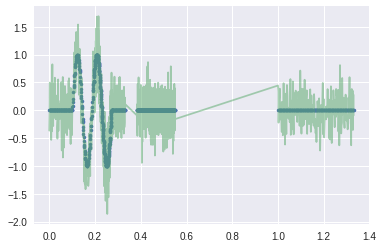

In [12]:
def signal_no_equip(N, fixed=True):
    # 3 parts separated in time, one with slight irregularities in time sampling
    # another with change of spacing and the last one with big outlier in spacing
    T = np.zeros(N)
    dt_implicit = 1 / N
    t0 = np.linspace(0, 2*int(N/6)-1, 2*int(N/6))
    if fixed:
        np.random.seed(1)
    e = np.random.normal(0, dt_implicit * 0.5, 2*int(N/6))
    T[0:2*int(N/6)] = t0 * dt_implicit + e
    shift = 30 * dt_implicit
    
    if fixed:
        np.random.seed(2)
    t0 = np.linspace(2*int(N/6), 3*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[2*int(N/6):3*int(N/6)] = shift + t0 * dt_implicit / 2 + e
    
    if fixed:
        np.random.seed(3)
    t0 = np.linspace(3*int(N/6), 4*int(N/6)-1, int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, int(N/6))
    T[3*int(N/6):4*int(N/6)] = t0 * 2 * dt_implicit + e
    
    if fixed:
        np.random.seed(4)
    t0 = np.linspace(4*int(N/6), N-1, N - 4*int(N/6))
    e = np.random.normal(0, dt_implicit * 0.5, N - 4*int(N/6))
    T[4*int(N/6):N] = 2 * shift + t0 * dt_implicit / 2 + e
    T.sort()

    #  signal is sinusoidal again with same frequency
    temp = np.zeros(N)
    segment_duration = int(N/3)
    init = int(N/10)
    times_segment = T[init: init + segment_duration]
    times_segment = times_segment - min(times_segment)
    freq_sin = 2 / (max(times_segment) - min(times_segment))
#     print("choosen freq is: ", freq_sin)
    temp[init: init + segment_duration] = np.sin(freq_sin * 2 * np.pi * times_segment)
    return temp, freq_sin, T
N = 1200
temp2, freq_sin, t2 = signal_no_equip(N, fixed=False)
print(freq_sin)
data2 = np.random.normal(0, 0.3, N) + temp2
plt.plot(t2, temp2, '.')
plt.plot(t2, data2, alpha=0.5)

mean value of the PSD:  0.0029484071704633233 or  0.0029660350104845313


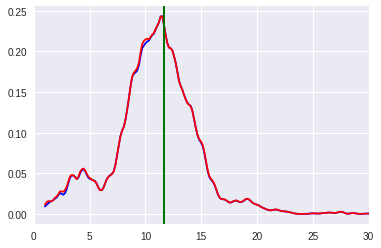

In [13]:
# obtencion de la psd dejando que calcule sus propias frequencias
df = 1 / (max(t2) - min(t2))
freqs = fftfreq(N, d=1/df)
freqs_lomb = np.delete(np.abs(freqs), 0)

frequency, power = LombScargle(t2, data2).autopower(maximum_frequency=1000, minimum_frequency=1)
pgram = signal.lombscargle(t2, data2, frequency * 2 * np.pi, normalize=True)
print("mean value of the PSD: ", np.mean(pgram), "or ", np.mean(power))
plt.figure(1)
plt.plot(frequency, pgram, "b")
plt.plot(frequency, power, 'r')
plt.axvline(freq_sin, color='k')
plt.axvline(freq_sin, color='g')
plt.xlim([0, 30])
plt.show()

# se obtiene resultados similares pero sabemos que astropy lo implementa en tiempo O(Nlog(N)) y scypy en tiempo O(N^2)

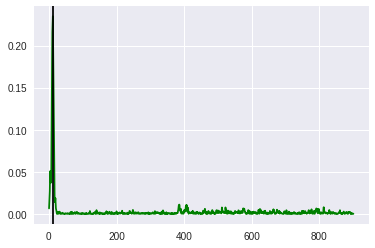

In [14]:
# NF viene de -(Nf // 2) + np.arange(Nf)
def get_psd(k, t, data, min_freq=None, data_per_peak=1):
    df = 1 / ((max(t) - min(t)) * data_per_peak)
    if min_freq is None:
        min_freq = 0.5 * df
    NK = len(k)
    if NK % 2 == 0: # par
        N = int(NK / 2)
    else:
        N = int((NK-1) / 2)
    
    max_freq = (N - 1) * df + min_freq
    
    frequency, power = LombScargle(t, data).autopower(maximum_frequency=max_freq, minimum_frequency=min_freq,
                                                     samples_per_peak=data_per_peak)
    if len(frequency) != N:
        raise ValueError("algo malo")
    
    return frequency, power, df
Nf = 2 * N
k = -(Nf // 2) + np.arange(Nf)
freqs, pw, df = get_psd(k, t2, data2)
plt.plot(freqs, pw, 'g')
plt.axvline(freq_sin, color='k')
# plt.xlim([0, 30])

[108.24200321 140.93071699 173.62951125 197.50775309 207.33291044
 201.36694484 181.08921327 150.64543974 116.05870979  84.34633706
  62.16068622  51.80955413  47.45367331]
[33.02141754 37.7387629  42.45610827 47.17345363 51.89079899 56.60814436
 61.32548972 66.04283508 70.76018044 75.47752581 80.19487117 84.91221653
 89.6295619 ]


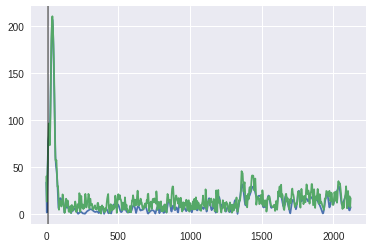

In [15]:
# calcula las nfft
def get_nfft(Nf, data, temp, t):
    dwindow = signal.tukey(len(temp), alpha=1./8)
    
    nfft_d = nfft_adjoint(t, dwindow * data, Nf)
    nfft_t = nfft_adjoint(t, dwindow * temp, Nf)
    k = (-(Nf // 2) + np.arange(Nf)) / (max(t) - min(t)) * (2 *np.pi)
    return nfft_d, nfft_t, k
Nf = N
nfft_d, nfft_t, k = get_nfft(Nf, data2, temp2, t2)
plt.plot(k[Nf//2-1:] * df, np.abs(nfft_t[Nf//2-1:]))
plt.plot(k[Nf//2-1:] * df, np.abs(nfft_d[Nf//2-1:]))
plt.axvline(freq_sin, color='k', alpha=0.5)

print(np.abs(nfft_t[(Nf//2)+7:(Nf//2) + 20]))
print(k[(Nf//2)+7:(Nf//2) + 20])

1.0


/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


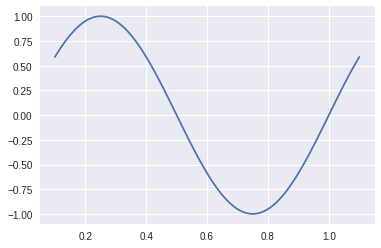

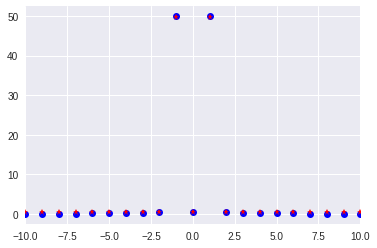

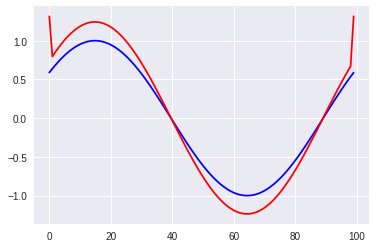

In [16]:
t = np.linspace(0.1, 1.1, 100)
freqq = 1 / (max(t) - min(t))
print(freqq)
d = np.sin(2 * np.pi * freqq * t)
plt.figure()
plt.plot(t, d)
nfft_freqs = (-(2*len(t)//2) + np.arange(2 * len(t))) / (max(t) - min(t))
fft_freqs = fftfreq(len(t), d=((max(t) - min(t)) / len(t)))
fft_d_test = fft(d)
nfft_d_test = nfft_adjoint(t, d, 2*len(t))
plt.figure()
plt.plot(fft_freqs, np.abs(fft_d_test), 'bo')
plt.plot(nfft_freqs, np.abs(nfft_d_test), 'r*')
plt.xlim([-10, 10])

# erase 0 frequency
# fft_d_test = np.delete(fft_d_test, 0)
# nfft_d_test = np.delete(fft_d_test, (2 * len(t))//2)
         
dy = ifft(fft_d_test)
dyy = nfft(t, nfft_d_test) / (2*len(t))
plt.figure()
plt.plot(dy, 'b')
plt.plot(dyy, 'r')

/home/pancho/.local/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


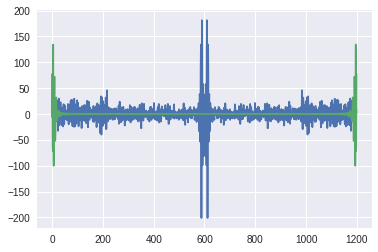

In [17]:
nfft_d, nfft_t, k = get_nfft(Nf, data2, temp2, t2)
fft_d, fft_t = get_fft(N, data2, temp2)
plt.plot(nfft_d)
plt.plot(fft_d)

In [18]:
# realizando una pequeña comprobacion del teorema de parseval
sum_time = (np.abs(temp2)**2).sum()
sum_freq = (np.abs(nfft_t)**2).sum()
print(sum_time, sum_freq / np.sqrt(2 * Nf))

# vemos que no se cumple parseval, esto era esperable dado 
#que aplicamos muchas mas frequencias que tiempos, para la inversa

dwindow = signal.tukey(len(temp2), alpha=1./8)
temp_back = nfft(t2, nfft_t)
sum_time_back = (np.abs(temp_back)**2).sum()
print(sum_time, sum_time_back / (2 * Nf) )
print("-------")

# vemos entonces que parseval no se cumple, por otro lado si usamos una matriz 
#cuadrada, i.e, misma cantidad de freqs que tiempos nos da:
Nf_test = N
nfft_d_test, nfft_t_test, k_test = get_nfft(Nf_test, data2, temp2, t2)
sum_freq = (np.abs(nfft_t_test)**2).sum()
print(sum_time, sum_freq / N)
temp_back = nfft(t2, nfft_t_test)
sum_time_back = (np.abs(temp_back)**2).sum()
print(sum_time, sum_time_back)

# vemos que tampoco se cumple incluso aplicamos la misma cantidad de frequencias que tiempos, esto nos dice que aun
# si se aplican igual frequencias, dado que los tiempos varias, no hay garantia de que la matriz sea invertible.
# por otro lado puede que el teorema de parseval no se aplique aqui.

205.22442714756465 15704.807900360916
205.22442714756465 1616342.0960622507
-------
205.22442714756465 641.1460977385714
205.22442714756465 3879221030.5494018


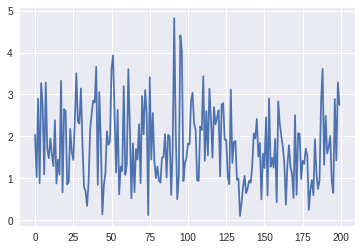

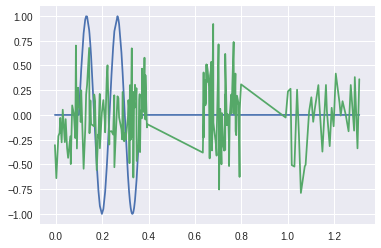

In [19]:
# el snr de los no espaciados
def snr_no_equip(N, only_noise=False, fixed=False):
    temp, freq_sin, t = signal_no_equip(N, fixed=fixed)
    if only_noise:
        if fixed:
            np.random.seed(12312)
        data = np.random.normal(0, 0.3, N)
    else:
        data = np.random.normal(0, 0.3, N) + temp
    
    # calcula la psd
    Nf = 4 * N
    k = -(Nf // 2) + np.arange(Nf)
    freqs, pw, df = get_psd(k, t, data)
    
    # repite la psd para obtener los datos con frequencias negativas, si Nf es par entonces el ultimo no se repite
    pw = np.append(pw, pw)
    if Nf % 2 == 0:
        pw = np.delete(pw, len(pw) - 1)
    
    nfft_d, nfft_t, k = get_nfft(Nf, data, temp, t)
    nfft_d = np.delete(nfft_d, 0) # remving the value corresponding to 0 frequency
    nfft_t = np.delete(nfft_t, 0)
    
    ## to get this as even remove another freq, for this time it will be the last one
    last_one = len(pw)-1
    nfft_d = np.delete(nfft_d, last_one)
    nfft_t = np.delete(nfft_t, last_one)
    pw = np.delete(pw, last_one)

    norm_sigma = 4 * df
    h_norm = (nfft_t * nfft_t.conjugate() / pw).sum()
    norm_corr = 4 * df / np.sqrt(h_norm.real * norm_sigma)
    corr = nfft_d * nfft_t.conjugate() / pw / (2*Nf)
    snr = nfft(t, corr) * norm_corr * (max(t) - min(t)) * (len(fft_d) - 1) / N
#     snr = np.roll(snr, len(snr) // 2)
    return t, np.abs(snr), data, temp
N = 200
t, snr, data, temp = snr_no_equip(N, only_noise=True, fixed=False)
plt.figure()
plt.plot(snr)

plt.figure()
plt.plot(t, temp)
plt.plot(t, data)

In [20]:
# analicemos el error asociado a muchas repeticiones
def repeat_snr_non_unif(N, n_repeat, only_noise=False):
    mean_snr = []
    max_snr = []
    median_snr = []
    std_snr = []
    for i in range(n_repeat):
        _, snr, _, _ = snr_no_equip(N, only_noise=only_noise, fixed=False)
        mean_snr.append(np.mean(snr))
        median_snr.append(np.median(snr))
        max_snr.append(np.max(snr))
        std_snr.append(np.std(snr))
    return mean_snr, median_snr, max_snr, std_snr

# usando misma cantidad de frequencias que de tiempos
rep = 100
N = 1000
mean, median, maxx, stdd = repeat_snr_non_unif(N, rep, only_noise=True)
print(":::::SNR parameters for {} repetitions for signal of only noise:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))
print("\n -------------------------- \n")
mean, median, maxx, stdd = repeat_snr_non_unif(N, rep, only_noise=False)
print(":::::SNR parameters for {} repetitions for signal of noise + template:::::".format(rep))
print("mean snr over is: {} +- {}".format(np.mean(mean), np.std(mean)))
print("median snr is: {} +- {}".format(np.mean(median), np.std(median)))
print("max snr is: {} +- {}".format(np.mean(maxx),np.std(maxx)))
print("std snr is: {} +- {}".format(np.mean(stdd),np.std(stdd)))

:::::SNR parameters for 100 repetitions for signal of only noise:::::
mean snr over is: 2.84141652895232 +- 5.879466629304671
median snr is: 2.8903880495816465 +- 6.156333290133472
max snr is: 5.14425170758177 +- 8.161764536140415
std snr is: 1.0110360145042272 +- 1.7611862433451366

 -------------------------- 

:::::SNR parameters for 100 repetitions for signal of noise + template:::::
mean snr over is: 8.599984466060265 +- 12.16407432265137
median snr is: 8.554383284723954 +- 12.227523129166347
max snr is: 16.74810198598798 +- 13.134934073365766
std snr is: 2.029329041610451 +- 1.3618679836379917


In [21]:
Nf = 67
k = -(Nf // 2) + np.arange(Nf)
kk = np.abs(k)
kk.sort()
print(k)
print(kk)
print(len(np.unique(kk))-1)

[-33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16
 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2
   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33]
[ 0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12
 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23 24
 24 25 25 26 26 27 27 28 28 29 29 30 30 31 31 32 32 33 33]
33


(array([  6.,  22.,  83., 174., 246., 211., 164.,  73.,  14.,   7.]),
 array([-0.62996753, -0.50057184, -0.37117616, -0.24178047, -0.11238478,
         0.01701091,  0.1464066 ,  0.27580228,  0.40519797,  0.53459366,
         0.66398935]),
 <a list of 10 Patch objects>)

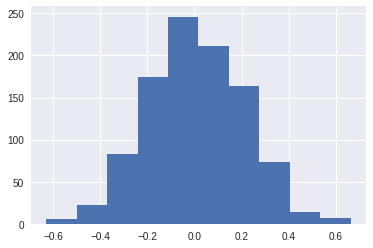

In [83]:
import scipy as sp
norm = sp.stats.norm(0, 0.2)
r = norm.rvs(1000)
plt.hist(r)